# ML Research
Автор: Душкина Надежда Андреевна, R4197

In [1]:
#%pip install catboost
#%pip install pandas
#%pip install numpy
#%pip install matplotlib
#%pip install seaborn
#%pip install scikit-learn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.inspection import permutation_importance

from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier

In [3]:
import mlflow
import os
os.environ['USER'] = 'Nadya Dushkina'

# Инициализация MLflow
mlflow.set_tracking_uri("http://178.72.151.49:5050")
mlflow.set_experiment("Insurance Cross Selling Classifier")

<Experiment: artifact_location='mlflow-artifacts:/2', creation_time=1764667633320, experiment_id='2', last_update_time=1764667633320, lifecycle_stage='active', name='Insurance Cross Selling Classifier', tags={}>

Работа с данными. Разделение всего объема на обучение и тестирование. Вычленение важных признаков. 
Кодирование категориальных признаков (превращение их в бинарныый код), нормализация числовых признаков.

In [4]:
data = pd.read_csv('train.csv')

train = data[:5_000_000]
test = data[5_000_000:]

In [5]:
train.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,0,Male,21,1,35.0,0,1-2 Year,Yes,65101.0,124.0,187,0
1,1,Male,43,1,28.0,0,> 2 Years,Yes,58911.0,26.0,288,1
2,2,Female,25,1,14.0,1,< 1 Year,No,38043.0,152.0,254,0
3,3,Female,35,1,1.0,0,1-2 Year,Yes,2630.0,156.0,76,0
4,4,Female,36,1,15.0,1,1-2 Year,No,31951.0,152.0,294,0


### Описание данных:
| Название признака | Тип | Описание  |
| :------- | :------ | :------- |
|id |числовой|Уникальный идентификатор клиента|
|Age|числовой|Возраст клиента|
|Gender|бинарный|Пол клиента|
|Driving_License|бинарный|0 для клиентов, не имеющих водительских прав, 1 для клиентов, имеющих водительские права|
|Region_Code|номинальный|Уникальный код региона клиента|
|Previously_Insured|бинарный|0 для клиентов, не имеющих страховки на транспортное средство, 1 для клиентов, имеющих страховку на транспортное средство|
|Vehicle_Age|номинальный|Возраст транспортного средства|
|Vehicle_Damage|бинарный|1: Клиент получил повреждение своего автомобиля в прошлом. 0: Клиент не получал повреждения своего автомобиля в прошлом|
|Annual_Premium|числовой|Сумма, которую клиент должен заплатить в качестве премии в течение года|
|Policy_Sales_Channel|номинальный|Анонимизированный код канала взаимодействия с клиентом, т. е. различные агенты, по почте, по телефону, лично и т. д.|
|Vintage|числовой|Количество дней, в течение которых клиент связан с компанией|
|Response (таргет)|бинарный|1 для заинтересованного клиента, 0 для незаинтересованного клиента|

In [6]:
# Оставляем только полезные столбцы
#columns_to_keep = ['Gender', 'Age', 'Driving_License', 'Region_Code', 'Previously_Insured', 'Vehicle_Age',	'Vehicle_Damage', 'Annual_Premium','Policy_Sales_Channel', 'Vintage', 'Response']
#train = train[columns_to_keep]
train = train.drop(columns=['id'])
train.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,Male,21,1,35.0,0,1-2 Year,Yes,65101.0,124.0,187,0
1,Male,43,1,28.0,0,> 2 Years,Yes,58911.0,26.0,288,1
2,Female,25,1,14.0,1,< 1 Year,No,38043.0,152.0,254,0
3,Female,35,1,1.0,0,1-2 Year,Yes,2630.0,156.0,76,0
4,Female,36,1,15.0,1,1-2 Year,No,31951.0,152.0,294,0


In [7]:
unique_B = data['Region_Code'].unique()
print(unique_B)

[35.  28.  14.   1.  15.  47.  45.   8.  11.   3.  10.  12.  37.  50.
 30.  46.  29.  16.  26.  25.  41.  48.   7.   4.  24.  36.  33.   2.
  9.  27.  18.  43.  49.  17.  13.  38.   6.  21.  23.   0.  19.   5.
 39.  44.  20.  40.  22.  32.  42.  31.  34.  51.  52.  39.2]


In [8]:
# Описательная статистика числовых признаков
train.describe()

,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06
mean,3.838755e+01,9.980264e-01,2.641528e+01,4.628668e-01,3.046855e+04,1.124040e+02,1.639189e+02,1.230562e-01
std,1.499676e+01,4.438136e-02,1.298993e+01,4.986193e-01,1.647620e+04,5.404819e+01,7.997458e+01,3.285017e-01
min,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,2.630000e+03,1.000000e+00,1.000000e+01,0.000000e+00
25%,2.400000e+01,1.000000e+00,1.500000e+01,0.000000e+00,2.527900e+04,2.900000e+01,9.900000e+01,0.000000e+00
50%,3.600000e+01,1.000000e+00,2.800000e+01,0.000000e+00,3.182400e+04,1.510000e+02,1.660000e+02,0.000000e+00
75%,4.900000e+01,1.000000e+00,3.500000e+01,1.000000e+00,3.945400e+04,1.520000e+02,2.320000e+02,0.000000e+00
max,8.500000e+01,1.000000e+00,5.200000e+01,1.000000e+00,5.401650e+05,1.630000e+02,2.990000e+02,1.000000e+00


In [9]:
# Описательная статистика категориальных признаков
train.describe(include = ['O'])

,Gender,Vehicle_Age,Vehicle_Damage
count,5000000,5000000,5000000
unique,2,3,2
top,Male,1-2 Year,Yes
freq,2707018,2600661,2514240


In [10]:
tr = train.copy()

In [11]:
# One-hot кодирование категориальных признаков
categorical_features = ['Gender', 'Vehicle_Damage']
tr = pd.get_dummies(tr, columns=categorical_features, drop_first=True)

In [12]:
vehicle_age = {'< 1 Year': 0, '1-2 Year': 1, '> 2 Years':2}
tr['Vehicle_Age'] = tr['Vehicle_Age'].map(vehicle_age)

In [13]:
# Нормализация числовых признаков
numeric_features = ['Age', 'Driving_License', 'Region_Code', 'Previously_Insured', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage']
scaler = StandardScaler()
tr[numeric_features] = scaler.fit_transform(tr[numeric_features])

In [14]:
tr = tr.drop(columns=['Driving_License','Annual_Premium'])
tr.head()

,Age,Region_Code,Previously_Insured,Vehicle_Age,Policy_Sales_Channel,Vintage,Response,Gender_Male,Vehicle_Damage_Yes
0,-1.159421,0.660875,-0.928297,1,0.214550,0.288605,0,True,True
1,0.307563,0.121996,-0.928297,2,-1.598647,1.551506,1,True,True
2,-0.892696,-0.955762,1.077241,0,0.732606,1.126371,0,False,False
3,-0.225886,-1.956537,-0.928297,1,0.806614,-1.099336,0,False,True
4,-0.159205,-0.878779,1.077241,1,0.732606,1.626530,0,False,False


In [15]:
# Описательная статистика числовых признаков
tr.describe()

,Age,Region_Code,Previously_Insured,Vehicle_Age,Policy_Sales_Channel,Vintage,Response
count,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06
mean,6.460539e-17,2.550138e-17,-4.832685e-17,6.032090e-01,1.748788e-17,-3.624763e-17,1.230562e-01
std,1.000000e+00,1.000000e+00,1.000000e+00,5.678246e-01,1.000000e+00,1.000000e+00,3.285017e-01
min,-1.226102e+00,-2.033520e+00,-9.282972e-01,0.000000e+00,-2.061198e+00,-1.924599e+00,0.000000e+00
25%,-9.593775e-01,-8.787794e-01,-9.282972e-01,0.000000e+00,-1.543141e+00,-8.117448e-01,0.000000e+00
50%,-1.592047e-01,1.219958e-01,-9.282972e-01,1.000000e+00,7.141038e-01,2.602143e-02,0.000000e+00
75%,7.076491e-01,6.608748e-01,1.077241e+00,1.000000e+00,7.326058e-01,8.512837e-01,0.000000e+00
max,3.108167e+00,1.969581e+00,1.077241e+00,2.000000e+00,9.361279e-01,1.689050e+00,1.000000e+00


In [16]:
trOne = tr.copy()

In [17]:
# Разделение на признаки (X) и целевую переменную (y)
X = trOne.drop(columns=['Response'])
y = trOne['Response']

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [16]:
X_train

,Age,Region_Code,Previously_Insured,Vehicle_Age,Policy_Sales_Channel,Vintage,Gender_Male,Vehicle_Damage_Yes
813726,0.841011,-1.417658,-0.928297,2,-1.598647,0.051029,True,True
3159354,0.907692,0.506909,-0.928297,2,-1.598647,-0.999304,True,True
2669419,-0.892696,-1.417658,1.077241,0,0.732606,-0.599177,True,False
853021,-0.892696,0.583892,1.077241,0,0.732606,1.626530,False,False
1982305,-1.159421,1.353719,1.077241,0,0.880622,-0.411618,False,False
...,...,...,...,...,...,...,...,...
88386,-0.025843,0.121996,1.077241,1,0.214550,1.151379,True,True
3329780,-0.292567,1.815615,1.077241,1,-1.931683,0.538684,False,True
1860563,-0.492610,-1.417658,-0.928297,0,0.732606,1.063851,False,True
2480230,0.774330,0.121996,-0.928297,1,-0.988081,-0.886769,True,True


In [ ]:
models = {
    'LogisticRegression': (LogisticRegression(max_iter=1000, random_state=42), {
        'C': [0.01, 0.1, 1, 10]
    }),
    'DecisionTree': (DecisionTreeClassifier(random_state=42), {
        'max_depth': [5, 10, 20, None],
        'min_samples_split': [2, 5, 10]
    }),
    'RandomForest': (RandomForestClassifier(random_state=42), {
        'n_estimators': [50, 100],
        'max_depth': [10, 20, None]
    }),
    'KNN': (KNeighborsClassifier(), {
        'n_neighbors': [3, 5, 7]
    })
}

In [18]:
from sklearn.metrics import precision_score, recall_score, f1_score, make_scorer, accuracy_score, roc_auc_score

In [ ]:

# --- Список для хранения результатов ---
results = []

# --- Основной цикл по моделям ---
for name, (model, params) in models.items():
    print(f"Training {name}...")
    grid = GridSearchCV(
        estimator=model,
        param_grid=params,
        scoring='f1',
        cv=3,
        n_jobs=-1,
        verbose=0
    )
    grid.fit(X_train, y_train)

    # Предсказания на validation
    y_pred = grid.predict(X_test)

    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    results.append({
        'Model': name,
        'Best_Params': grid.best_params_,
        'Precision': precision,
        'Recall': recall,
        'F1': f1
    })

In [ ]:
# --- Таблица с результатами ---
results_df = pd.DataFrame(results).sort_values(by='F1', ascending=False)
print(results_df)

In [ ]:
models = {
    'LogisticRegression': (LogisticRegression(max_iter=1000, random_state=42), {
        'C': [0.1]
    }),
    'DecisionTree': (DecisionTreeClassifier(random_state=42), {
        'max_depth': [None],
        'min_samples_split': [2]
    }),
    'RandomForest': (RandomForestClassifier(random_state=42), {
        'n_estimators': [50],
        'max_depth': [None]
    }),
    'KNN': (KNeighborsClassifier(), {
        'n_neighbors': [3]
    }),
    'CatBoost': (CatBoostClassifier(random_state=42, verbose=0), {
        'iterations': [50, 100],
        'depth': [7],
        'learning_rate': [0.1]
    })
}

In [ ]:
# --- Список для хранения результатов ---
results = []

# --- Основной цикл по моделям ---
for name, (model, params) in models.items():
    print(f"Training {name}...")
    grid = GridSearchCV(
        estimator=model,
        param_grid=params,
        scoring='f1',
        cv=3,
        n_jobs=-1,
        verbose=0
    )
    grid.fit(X_train, y_train)

    # Предсказания на validation
    y_pred = grid.predict(X_test)

    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    results.append({
        'Model': name,
        'Best_Params': grid.best_params_,
        'Precision': precision,
        'Recall': recall,
        'F1': f1
    })

In [19]:
# 1. Decision Tree
#tree_param_grid = {'max_depth': [3, 5, 10], 'min_samples_split': [5, 10, 15]}
#tree_model = GridSearchCV(DecisionTreeClassifier(random_state=42), tree_param_grid, cv=5)
#tree_model.fit(X_train, y_train)
#print("Decision Tree Best Params:", tree_model.best_params_)

# 2. Random Forest
# rf_param_grid = {'n_estimators': [100, 200], 'max_depth': [5, 10], 'min_samples_split': [3, 5, 10]}
# rf_model = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, cv=5)
# rf_model.fit(X_train, y_train)
# print("Random Forest Best Params:", rf_model.best_params_)

# 3. K-Nearest Neighbors (KNN)
knn_param_grid = {'n_neighbors': [3, 5, 7, 9]}
knn_model = GridSearchCV(KNeighborsClassifier(), knn_param_grid, cv=3)
knn_model.fit(X_train, y_train)
print("KNN Best Params:", knn_model.best_params_)

KNN Best Params: {'n_neighbors': 9}


In [22]:
# Функция для оценки модели
def evaluate_model(model, name):
    print(f"\n--- {name} ---")
    mlflow.start_run(run_name = name)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # mlflow.log_params(model.best_params_)
    mlflow.log_param("n_neighbors", 11)

    # Матрики качества
    mlflow.log_metric("accuracy", round(acc, 4))
    mlflow.log_metric("precision", round(precision, 4))
    mlflow.log_metric("recall", round(recall, 4))
    mlflow.log_metric("f1", round(f1, 4))
    mlflow.log_metric("roc_auc", round(roc_auc, 4))

    # Сохраняем модель
    try:
        mlflow.sklearn.log_model(model, f"{name}_model")
    except:
            print(f"Could not log model for {name}.")
    mlflow.end_run()
    
    # Матрица ошибок
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Response', 'Response'], yticklabels=['Not Response', 'Response'])
    plt.title(f'Confusion Matrix for {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # Отчет классификации
    print(classification_report(y_test, y_pred))
    
    # Важность признаков (только для деревьев)
    if hasattr(model, "best_estimator_") and hasattr(model.best_estimator_, "feature_importances_"):
        feature_importances = model.best_estimator_.feature_importances_
        feature_names = X.columns
        importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
        importance_df = importance_df.sort_values(by='Importance', ascending=False)
        print("\nFeature Importances:")
        print(importance_df)

# Оценка моделей
# evaluate_model(tree_model, "Decision Tree")
# evaluate_model(rf_model, "Random Forest")
# evaluate_model(knn_model, "KNN")


--- KNN ---


2025/12/13 23:58:27 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/13 23:58:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run KNN at: http://178.72.151.49:5050/#/experiments/2/runs/5cf79f4abaa541099484bc60521c8e46
🧪 View experiment at: http://178.72.151.49:5050/#/experiments/2


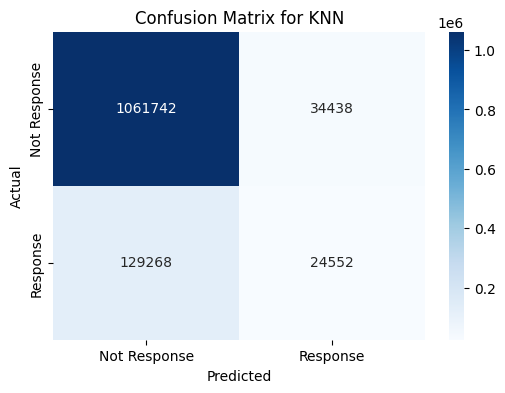

              precision    recall  f1-score   support

           0       0.89      0.97      0.93   1096180
           1       0.42      0.16      0.23    153820

    accuracy                           0.87   1250000
   macro avg       0.65      0.56      0.58   1250000
weighted avg       0.83      0.87      0.84   1250000



In [25]:
knn_model = KNeighborsClassifier(n_neighbors = 11)
knn_model.fit(X_train, y_train)
evaluate_model(knn_model, "KNN")

In [ ]:
# 4. Support Vector Machine (SVM)
svm_param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
svm_model = GridSearchCV(SVC(random_state=42), svm_param_grid, cv=3)
svm_model.fit(X_train, y_train)
print("SVM Best Params:", svm_model.best_params_)

evaluate_model(svm_model, "SVM")